## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import age
from snprop import survey
from variaIa import tools
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from variaIa import massevol
from importlib import reload
from variaIa import stretchevol
from scipy.stats import truncnorm
from scipy.optimize import fmin_slsqp
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "EB Garamond",
    "axes.labelsize": 'x-large',
    "xtick.labelsize": 'x-large',
    "ytick.labelsize": 'x-large'})
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [29]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'LOWZ': (1, 0, 0, 1),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_nLOWZ = df_nc[df_nc['survey'] != 'LOWZ']
df_SNF = df_nc[df_nc['survey'] == 'SNF']
df_LOWZ = df_nc[df_nc['survey'] == 'LOWZ']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', optio…

### Use SED fitted SNf data

In [19]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
sed = sed.loc[sed['name'].str.contains('SNF|LSQ|PTF', na=False, regex=True)]
sed = sed.rename(columns={'mass': 'hostmass', 'z': 'redshifts'})
sed['hostmass_err'] = np.sqrt((sed['mass_uppererr']**2 +
                               sed['mass_lowerr']**2)/2)
sedsnf_df = df_nc.loc[df_nc['survey'] == 'SNF'].copy()
sedsnf_df['hostmass'] = sed['hostmass'].values
sedsnf_df['hostmass_err'] = sed['hostmass_err'].values
sedsnf_df_nonan = sedsnf_df.loc[~np.isnan(sedsnf_df['hostmass'])]

In [4]:
df_fit = pd.concat([sedsnf_df_nonan,
                    df_nc[(df_nc['survey'] != 'SNF') &
                          (df_nc['survey'] != 'LOWZ')]])
df_fit = df_fit.loc[df_fit['hostmass'] > 7]

### Compare SNF SED masses to LOWZ

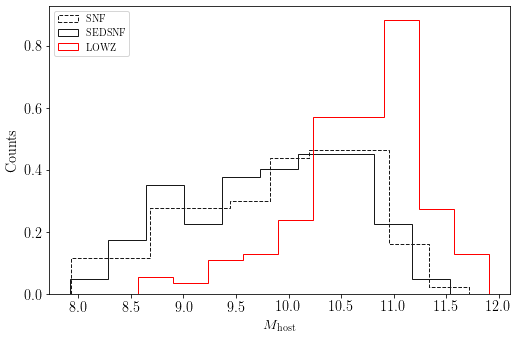

In [33]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.hist(df_SNF['hostmass'],
        color=colors['SNF'], histtype='step', ls='--',
        density=True, label='SNF')
ax.hist(sedsnf_df_nonan['hostmass'],
        color=colors['SNF'], histtype='step',
        density=True, label='SEDSNF')
ax.hist(df_LOWZ.loc[df_LOWZ['hostmass'] > 7.3]['hostmass'],
        color=colors['LOWZ'], histtype='step',
        density=True, label='LOWZ')

# ax.axhline(0, color='k', lw=1, ls='-')
# ax.axvline(10.0, color='k', lw=1, ls='--')

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel('Counts', fontsize='x-large')

ax.tick_params(labelsize='x-large')

ax.legend()

fig.savefig('../../../Images/pdf/mass_hists-SNFvLOWZ.pdf', bbox_inches='tight')

## Use of `massevol` to determine a mass/age relationship

#### SED SNF only

In [5]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
evol4G4M4S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol3G3M4S')
evol3G3M4S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None]
evol3G3M3S_sed_SNF = gen.fit(sedsnf_df_nonan, limits=None)

gen.set_model('Evol2G2M4S')
evol2G2M4S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol2G2M3S')
evol2G2M3S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol2G2M2S')
evol2G2M2S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol1G1M2S')
evol1G1M2S_sed_SNF = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol1G1M1S')
evol1G1M1S_sed_SNF = gen.fit(sedsnf_df_nonan)

mod_list_sed_SNF = [evol1G1M1S_sed_SNF, evol1G1M2S_sed_SNF,
                    evol2G2M2S_sed_SNF, evol2G2M3S_sed_SNF, evol2G2M4S_sed_SNF,
                    evol3G3M3S_sed_SNF, evol3G3M4S_sed_SNF, evol4G4M4S_sed_SNF]
mod_name_sed_SNF = ['Evol'+mod.__doc__ for mod in mod_list_sed_SNF]

pp = PrettyPrinter()
for mod in mod_list_sed_SNF:
    print(mod.__doc__)
    pp.pprint(mod.param)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/massevol.py:487: RuntimeWarning: invalid value encountered in log
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1761: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


1G1M1S
{'mu': 9.82187024818149, 'sigma': 0.7388697193607624}
1G1M2S
{'mu': 10.19404842935602,
 'sigmadown': 0.9689470171505654,
 'sigmaup': 0.4785890833911222}
2G2M2S
{'mu_1': 9.322308178865338,
 'mu_2': 10.341674380141377,
 'sigma_1': 0.5729080243370844,
 'sigma_2': 0.4997964251749382}
2G2M3S
{'mu': 10.556086116981012,
 'mu_1': 9.336756025455028,
 'sigma_1': -0.5750047677241205,
 'sigmadown': 0.696255631348485,
 'sigmaup': 0.32783825843026954}
2G2M4S
{'mu_o': 10.552854646793032,
 'mu_y': 9.246280793611174,
 'sigmad_o': 0.691540893647918,
 'sigmad_y': 0.5170665825395983,
 'sigmau_o': 0.3288749253029364,
 'sigmau_y': -0.6374655563831979}
3G3M3S
{'a': 1.1478890684428855,
 'mu_1': 9.323321234718593,
 'mu_2': 10.325248447834817,
 'mu_3': 10.156051119937398,
 'sigma_1': -0.5729318307448307,
 'sigma_2': -0.46881472169279076,
 'sigma_3': 0.00013172013625135438}
3G3M4S
{'a': 0.6522248924486513,
 'mu': 10.335622510333943,
 'mu_1': 9.342064952338028,
 'mu_2': 10.560197765503492,
 'sigma_1': -0.5

Evol2G2M2S
110
Evol2G2M3S
110
Evol2G2M4S
110


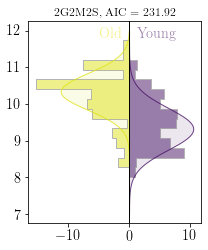

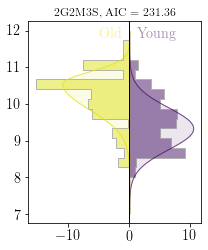

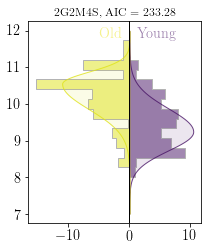

In [6]:
# for name, model in zip(mod_name_sed_SNF[:2], mod_list_sed_SNF[:2]):
#     fig = plt.figure(figsize=[7, 3.5], facecolor='w')
#     ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#     
#     print(name)
#     model.show_model_tot(ax=ax)
#     plt.title(model.__doc__)
#     # plt.close()
#     # 
#     # fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_SED-nonan_all.pdf',
#     #             bbox_inches='tight')
#     # fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_SED-nonan_all.png',
#     #             bbox_inches='tight', dpi=600)
    
for name, model in zip(mod_name_sed_SNF[2:-3], mod_list_sed_SNF[2:-3]):
    fig = plt.figure(figsize=[3, 3.5], facecolor='w')
    # ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.1, 0.12, 0.8, 0.8])
 
    print(name)
    print(len(model.pd))
    # gen.set_model(name)
    # mod = gen.model(snf_sed_nonan)
    # mod.param = model.param
    # model.scatter(ax=ax, model=False)
    model.show_hist(ax=axh, bins=15)
    model.show_model(ax=axh,
                     o_factor=-model.amp*np.sum(1-model.py),
                     y_factor=model.amp*np.sum(model.py),
                     # facealpha=0,
                     # edgealpha=1,
                     lw=1, zorder=8)
    
    # axh.set_ylim(*ax.get_ylim())
    # axh.set_yticks([])
    # axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    # axh.set_frame_on(False)
    
    plt.suptitle(model.__doc__ + f', AIC = {model.get_aic():.2f}')
    # plt.close()
# 
    fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_histonly_SED_SNF-nonan.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_histonly_SED_SNF-nonan.png',
                bbox_inches='tight', dpi=600)

## Plot fraction of y as a function of mass

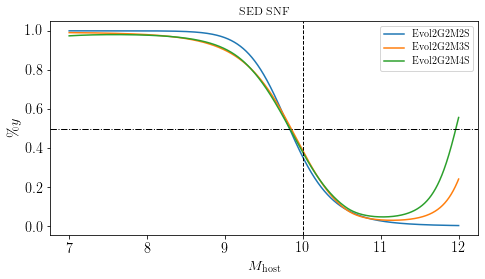

In [7]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.10, 0.85, 0.85])

for mod, name in zip(mod_list_sed_SNF[2:-3], mod_name_sed_SNF[2:-3]):
    Mlin = np.linspace(mod.floor, mod.ceil, 3000)
    l_y = mod.plot_y(Mlin)
    l_o = mod.plot_o(Mlin)
    yo = l_y/(l_y+l_o)
    ax.plot(Mlin, yo, label=name)

ax.axhline(0.5, ls='-.', color='k', lw=1)
ax.axvline(10.0, ls='--', color='k', lw=1)

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel(r'$\%y$', fontsize='x-large')
ax.tick_params(labelsize='x-large')

ax.legend()
ax.set_title('SED SNF')

fig.savefig('../../../Images/pdf/model_mass_yfrac-sed_snf.pdf', bbox_inches='tight')

#### Best SED SNF model

Text(0.5, 0.98, 'Asymmetric Howell')

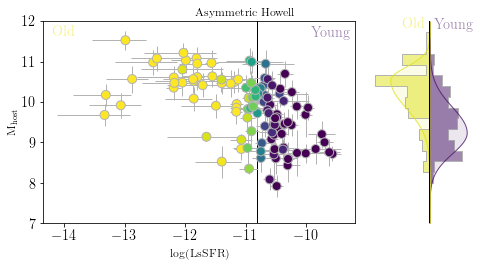

In [8]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
axh = fig.add_axes([0.75, 0.12, 0.2, 0.8])

evol2G2M4S_sed_SNF.scatter(ax=ax, model=False)
evol2G2M4S_sed_SNF.show_hist(ax=axh, bins=15)
evol2G2M4S_sed_SNF.show_model(ax=axh,
                 o_factor=-evol2G2M4S_sed_SNF.amp*np.sum(1-evol2G2M4S_sed_SNF.py),
                 y_factor=evol2G2M4S_sed_SNF.amp*np.sum(evol2G2M4S_sed_SNF.py),
                 # facealpha=0,
                 # edgealpha=1,
                 lw=1, zorder=8)

axh.set_ylim(*ax.get_ylim())
axh.set_yticks([])
axh.set_xticks([])

axh.axvline(0, color='k', lw=1, zorder=10)

axh.set_frame_on(False)

plt.suptitle('Asymmetric Howell')
# plt.close()

# fig.savefig('../../../Images/pdf/model_mass_' + evol2G2M4S.__doc__ + '_hist_SED-nonan.pdf',
#             bbox_inches='tight')
# fig.savefig('../../../Images/png/model_mass_' + evol2G2M4S.__doc__ + '_hist_SED-nonan.png',
#             bbox_inches='tight', dpi=600)

#### SNF only

In [9]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
evol4G4M4S_SNF = gen.fit(df_nc.loc[df_nc['survey'] == 'SNF'])

gen.set_model('Evol3G3M4S')
evol3G3M4S_SNF = gen.fit(df_nc.loc[df_nc['survey'] == 'SNF'])

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None]
evol3G3M3S_SNF = gen.fit(df_nc.loc[df_nc['survey'] == 'SNF'], limits=None)

gen.set_model('Evol2G2M4S')
evol2G2M4S_SNF = gen.fit(df_nc.loc[df_nc['survey'] == 'SNF'])

gen.set_model('Evol2G2M3S')
evol2G2M3S_SNF = gen.fit(df_nc.loc[df_nc['survey'] == 'SNF'])

gen.set_model('Evol2G2M2S')
evol2G2M2S_SNF = gen.fit(df_nc.loc[df_nc['survey'] == 'SNF'])

gen.set_model('Evol1G1M2S')
evol1G1M2S_SNF = gen.fit(df_nc.loc[df_nc['survey'] == 'SNF'])

gen.set_model('Evol1G1M1S')
evol1G1M1S_SNF = gen.fit(df_nc.loc[df_nc['survey'] == 'SNF'])

mod_list_SNF = [evol1G1M1S_SNF, evol1G1M2S_SNF,
                evol2G2M2S_SNF, evol2G2M3S_SNF, evol2G2M4S_SNF,
                evol3G3M3S_SNF, evol3G3M4S_SNF, evol4G4M4S_SNF]
mod_name_SNF = ['Evol'+mod.__doc__ for mod in mod_list_SNF]

pp = PrettyPrinter()
for mod in mod_list_SNF:
    print(mod.__doc__)
    pp.pprint(mod.param)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1G1M1S
{'mu': 9.899630980610967, 'sigma': 0.8105236537247464}
1G1M2S
{'mu': 10.4951757629179,
 'sigmadown': 1.1534054839846752,
 'sigmaup': 0.40492235992870496}
2G2M2S
{'mu_1': 9.355303033542036,
 'mu_2': 10.58211916920787,
 'sigma_1': 0.6355129718499912,
 'sigma_2': 0.37068580739664625}
2G2M3S
{'mu': 10.67634783044062,
 'mu_1': 9.368291659456832,
 'sigma_1': -0.6456618441761646,
 'sigmadown': 0.5301451975246523,
 'sigmaup': 0.33422127145436775}
2G2M4S
{'mu_o': 10.683307749935524,
 'mu_y': 9.46898513064532,
 'sigmad_o': 0.5444443894420778,
 'sigmad_y': 0.7067521064945528,
 'sigmau_o': 0.3321842201276239,
 'sigmau_y': 0.5842311115181635}
3G3M3S
{'a': 0.9026559561499145,
 'mu_1': 9.424390077864322,
 'mu_2': 10.593237047066372,
 'mu_3': 8.74484493028906,
 'sigma_1': 0.6272278131302066,
 'sigma_2': 0.36030564269752263,
 'sigma_3': 0.4164735026407387}
3G3M4S
{'a': 2.155736667244379,
 'mu': 10.76961717354363,
 'mu_1': 9.144934114079955,
 'mu_2': 10.444079704837018,
 'sigma_1': 0.512845511872

Evol2G2M2S
114
Evol2G2M3S
114
Evol2G2M4S
114


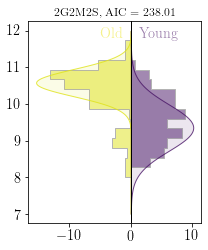

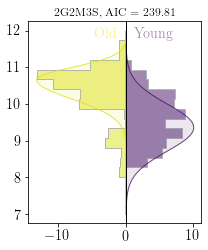

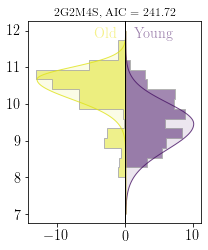

In [10]:
# for name, model in zip(mod_name_SNF[:2], mod_list_SNF[:2]):
#     fig = plt.figure(figsize=[7, 3.5], facecolor='w')
#     ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#     
#     print(name)
#     model.show_model_tot(ax=ax)
#     plt.title(model.__doc__)
#     # plt.close()
#     # 
#     # fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '-nonan_all.pdf',
#     #             bbox_inches='tight')
#     # fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '-nonan_all.png',
#     #             bbox_inches='tight', dpi=600)
    
for name, model in zip(mod_name_SNF[2:-3], mod_list_SNF[2:-3]):
    fig = plt.figure(figsize=[3, 3.5], facecolor='w')
    #ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.10, 0.12, 0.8, 0.8])
 
    print(name)
    print(len(model.pd))
    # gen.set_model(name)
    # mod = gen.model(snf_nonan)
    # mod.param = model.param
    # model.scatter(ax=ax, model=False)
    model.show_hist(ax=axh, bins=15)
    model.show_model(ax=axh,
                     o_factor=-model.amp*np.sum(1-model.py),
                     y_factor=model.amp*np.sum(model.py),
                     # facealpha=0,
                     # edgealpha=1,
                     lw=1, zorder=8)
    
    # axh.set_ylim(*ax.get_ylim())
    # axh.set_yticks([])
    # axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    # axh.set_frame_on(False)
    
    plt.suptitle(model.__doc__ + f', AIC = {model.get_aic():.2f}')
    # plt.close()
# 
    fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_histonly_SNF.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_histonly_SNF.png',
                bbox_inches='tight', dpi=600)

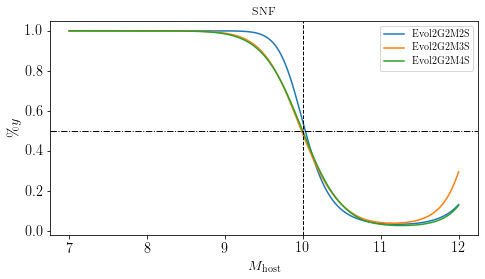

In [11]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.10, 0.85, 0.85])

for mod, name in zip(mod_list_SNF[2:-3], mod_name_SNF[2:-3]):
    Mlin = np.linspace(mod.floor, mod.ceil, 3000)
    l_y = mod.plot_y(Mlin)
    l_o = mod.plot_o(Mlin)
    yo = l_y/(l_y+l_o)
    ax.plot(Mlin, yo, label=name)
    
# mod = mod_list_SNF[-1]
# name = mod_name_SNF[-1]
# Mlin = np.linspace(mod.floor, mod.ceil, 3000)
# l_y = mod.plot_y(Mlin)
# l_o = mod.plot_o(Mlin)
# yo = l_y/(l_y+l_o)
# ax.plot(Mlin, yo, label=name)

ax.axhline(0.5, ls='-.', color='k', lw=1)
ax.axvline(10.0, ls='--', color='k', lw=1)

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel(r'$\%y$', fontsize='x-large')
ax.tick_params(labelsize='x-large')

ax.legend()
ax.set_title('SNF')

fig.savefig('../../../Images/pdf/model_mass_yfrac-snf.pdf', bbox_inches='tight')

#### All samples combined with SED SNF

In [12]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S_sed = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S_sed = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, (5, 15), (-1, 1)]
evol3G3M3S_sed = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S_sed = gen.fit(df_fit, limits=None)

mod_list_sed = [evol1G1M1S_sed, evol1G1M2S_sed,
                evol2G2M2S_sed, evol2G2M3S_sed, evol2G2M4S_sed,
                evol3G3M3S_sed, evol3G3M4S_sed, evol4G4M4S_sed]
mod_name_sed = ['Evol'+mod.__doc__ for mod in mod_list_sed]

pp = PrettyPrinter()
for mod in mod_list_sed:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 10.115948936767756, 'sigma': 0.7936336156936603}
1G1M2S
{'mu': 10.537081210470074,
 'sigmadown': 1.0532813466253161,
 'sigmaup': 0.5175961858983374}
2G2M2S
{'mu_1': 9.626399462519458,
 'mu_2': 10.729864285411596,
 'sigma_1': 0.6954419805907796,
 'sigma_2': -0.4163648021668908}
2G2M3S
{'mu': 10.80407178236592,
 'mu_1': 9.646031067372641,
 'sigma_1': 0.7104183550835206,
 'sigmadown': -0.5122358236458001,
 'sigmaup': 0.37848640451723103}
2G2M4S
{'mu_o': 10.739040324149709,
 'mu_y': 9.341005384239379,
 'sigmad_o': 0.4838947281224723,
 'sigmad_y': 0.5090532946899202,
 'sigmau_o': 0.3940507772250669,
 'sigmau_y': 0.9548941055258211}
3G3M3S
{'a': 0.9399270164988753,
 'mu_1': 9.701756439016641,
 'mu_2': 10.733992296290406,
 'mu_3': 9.124469141327797,
 'sigma_1': 0.7284459133327791,
 'sigma_2': 0.4055411606162702,
 'sigma_3': 2.5527462306557634e-05}
3G3M4S
{'a': 0.8621915131958199,
 'mu': 9.085939809793636,
 'mu_1': 9.712299376999097,
 'mu_2': 10.77153251010919,
 'sigma_1': 0.7357

Evol2G2M2S
544
Evol2G2M3S
544
Evol2G2M4S
544


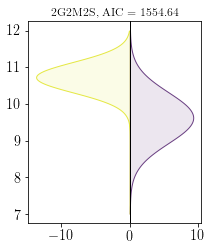

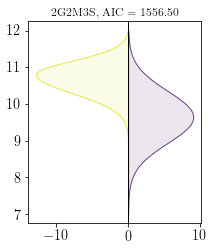

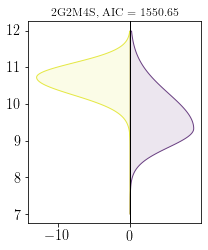

In [13]:
# for name, model in zip(mod_name_sed[:2], mod_list_sed[:2]):
#     fig = plt.figure(figsize=[7, 3.5], facecolor='w')
#     ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#     
#     print(name)
#     model.show_model_tot(ax=ax)
#     plt.title(model.__doc__)
#     # plt.close()
#     # 
#     # fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_SED-nonan_all.pdf',
#     #             bbox_inches='tight')
#     # fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_SED-nonan_all.png',
#     #             bbox_inches='tight', dpi=600)
    
for name, model, hist in zip(mod_name_sed[2:-3], mod_list_sed[2:-3], mod_list_SNF[2:-3]):
    fig = plt.figure(figsize=[3, 3.5], facecolor='w')
    # ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.1, 0.12, 0.8, 0.8])
 
    print(name)
    print(len(model.pd))
    # gen.set_model(name)
    # mod = gen.model(snf_sed_nonan)
    # mod.param = model.param
    # model.scatter(ax=ax, model=False)
    # hist.show_hist(ax=axh, bins=15)
    model.show_model(ax=axh,
                     o_factor=-hist.amp*np.sum(1-hist.py),
                     y_factor=hist.amp*np.sum(hist.py),
                     # facealpha=0,
                     # edgealpha=1,
                     lw=1, zorder=8)
    
    # axh.set_ylim(*ax.get_ylim())
    # axh.set_yticks([])
    # axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    # axh.set_frame_on(False)
    
    plt.suptitle(model.__doc__ + f', AIC = {model.get_aic():.2f}')
    # plt.close()
# 
    fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_histonly_SED_ALL-nonan.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_histonly_SED_ALL-nonan.png',
                bbox_inches='tight', dpi=600)

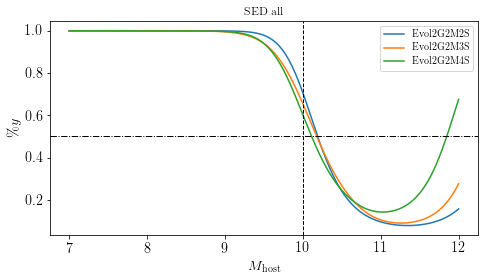

In [14]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.10, 0.85, 0.85])

for mod, name in zip(mod_list_sed[2:-3], mod_name_sed[2:-3]):
    Mlin = np.linspace(mod.floor, mod.ceil, 3000)
    l_y = mod.plot_y(Mlin)
    l_o = mod.plot_o(Mlin)
    yo = l_y/(l_y+l_o)
    ax.plot(Mlin, yo, label=name)

ax.axhline(0.5, ls='-.', color='k', lw=1)
ax.axvline(10.0, ls='--', color='k', lw=1)

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel(r'$\%y$', fontsize='x-large')
ax.tick_params(labelsize='x-large')

ax.legend()
ax.set_title('SED all')

fig.savefig('../../../Images/pdf/model_mass_yfrac-sed_all.pdf', bbox_inches='tight')

#### All samples combined with SNF

In [15]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S = gen.fit(df_nLOWZ, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S = gen.fit(df_nLOWZ, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, (5, 15), (-1, 1)]
evol3G3M3S = gen.fit(df_nLOWZ, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S = gen.fit(df_nLOWZ, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S = gen.fit(df_nLOWZ, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S = gen.fit(df_nLOWZ, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S = gen.fit(df_nLOWZ, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S = gen.fit(df_nLOWZ, limits=None)

mod_list = [evol1G1M1S, evol1G1M2S,
            evol2G2M2S, evol2G2M3S, evol2G2M4S,
            evol3G3M3S, evol3G3M4S, evol4G4M4S]
mod_name = ['Evol'+mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 10.104352886374246, 'sigma': 0.8292639883022892}
1G1M2S
{'mu': 10.662090451190345,
 'sigmadown': 1.1669661221157548,
 'sigmaup': 0.4497503515285808}
2G2M2S
{'mu_1': 9.611535849502019,
 'mu_2': 10.745486884304857,
 'sigma_1': 0.7517302054089509,
 'sigma_2': 0.39488966657194086}
2G2M3S
{'mu': 10.73462100868877,
 'mu_1': 9.610885022154978,
 'sigma_1': 0.7512771457721218,
 'sigmadown': -0.38544705304536986,
 'sigmaup': 0.401118755680351}
2G2M4S
{'mu_o': 10.721674920209857,
 'mu_y': 9.522995101616639,
 'sigmad_o': 0.3845540683495961,
 'sigmad_y': 0.6966678640264713,
 'sigmau_o': 0.4025862717188009,
 'sigmau_y': 0.827124521923235}
3G3M3S
{'a': 0.9500658682005619,
 'mu_1': 9.665699232473312,
 'mu_2': 10.768175991268349,
 'mu_3': 8.419113343540356,
 'sigma_1': 0.6953217753849388,
 'sigma_2': 0.38565219068579165,
 'sigma_3': -0.9999990359534745}
3G3M4S
{'a': 0.9435080848668106,
 'mu': 8.836495212429723,
 'mu_1': 9.667743923008988,
 'mu_2': 10.769646396373345,
 'sigma_1': 0.6984990

Evol2G2M2S
569
Evol2G2M3S
569
Evol2G2M4S
569


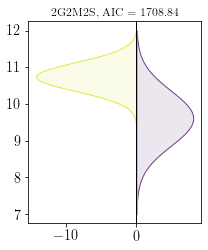

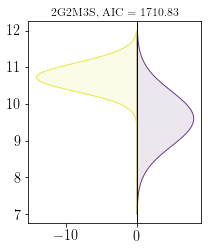

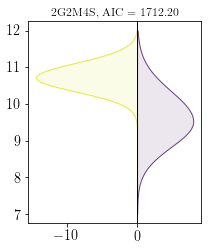

In [16]:
# for name, model in zip(mod_name[:2], mod_list[:2]):
#     fig = plt.figure(figsize=[7, 3.5], facecolor='w')
#     ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#     
#     print(name)
#     model.show_model_tot(ax=ax)
#     plt.title(model.__doc__)
#     # plt.close()
#     # 
#     # fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '-nonan_all.pdf',
#     #             bbox_inches='tight')
#     # fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '-nonan_all.png',
#     #             bbox_inches='tight', dpi=600)
    
for name, model, hist in zip(mod_name[2:-3], mod_list[2:-3], mod_list_sed_SNF[2:-3]):
    fig = plt.figure(figsize=[3, 3.5], facecolor='w')
    # ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.1, 0.12, 0.8, 0.8])
 
    print(name)
    print(len(model.pd))
    # gen.set_model(name)
    # mod = gen.model(snf_nonan)
    # mod.param = model.param
    # model.scatter(ax=ax, model=False)
    # hist.show_hist(ax=axh, bins=15)
    model.show_model(ax=axh,
                     o_factor=-hist.amp*np.sum(1-hist.py),
                     y_factor=hist.amp*np.sum(hist.py),
                     # facealpha=0,
                     # edgealpha=1,
                     lw=1, zorder=8)
    
    # axh.set_ylim(*ax.get_ylim())
    # axh.set_yticks([])
    # axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    #axh.set_frame_on(False)
    
    plt.suptitle(model.__doc__ + f', AIC = {model.get_aic():.2f}')
    # plt.close()
# 
    fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_histonly_ALL.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_histonly_ALL.png',
                bbox_inches='tight', dpi=600)

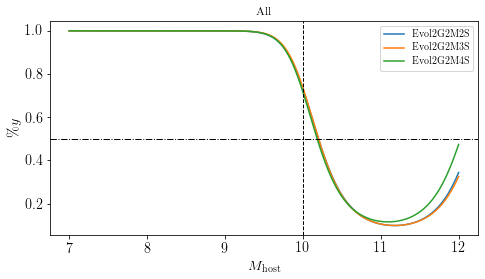

In [17]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.10, 0.85, 0.85])

for mod, name in zip(mod_list[2:-3], mod_name[2:-3]):
    Mlin = np.linspace(mod.floor, mod.ceil, 3000)
    l_y = mod.plot_y(Mlin)
    l_o = mod.plot_o(Mlin)
    yo = l_y/(l_y+l_o)
    ax.plot(Mlin, yo, label=name)

ax.axhline(0.5, ls='-.', color='k', lw=1)
ax.axvline(10.0, ls='--', color='k', lw=1)

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel(r'$\%y$', fontsize='x-large')
ax.tick_params(labelsize='x-large')

ax.legend()
ax.set_title('All')

fig.savefig('../../../Images/pdf/model_mass_yfrac-all.pdf', bbox_inches='tight')

## Plot the 3 best yfrac

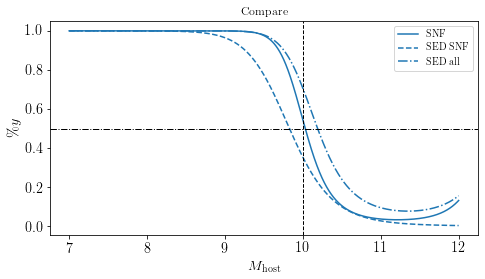

In [18]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.10, 0.85, 0.85])

for mod, name, ls in zip([mod_list_SNF[2], mod_list_sed_SNF[2], mod_list_sed[2]],
                         ['SNF', 'SED SNF', 'SED all'],
                         ['-', '--', '-.']):
    Mlin = np.linspace(mod.floor, mod.ceil, 3000)
    l_y = mod.plot_y(Mlin)
    l_o = mod.plot_o(Mlin)
    yo = l_y/(l_y+l_o)
    ax.plot(Mlin, yo, ls=ls,
            color='C0', label=name)
    
# mod = mod_list_SNF[2]
# Mlin = np.linspace(mod.floor, mod.ceil, 3000)
# l_y = mod.plot_y(Mlin)
# l_o = mod.plot_o(Mlin)
# yo = l_y/(l_y+l_o)
# uyo = 1-yo
# duyo = [(uyo[i] - uyo[i-1])/(Mlin[i] - Mlin[i-1]) for i in range(len(Mlin)-1)]
# 
# ax.plot(Mlin[:-1], duyo, label='Dérivée 1-SNF', color='C1')
# ax.plot(Mlin, mod.plot_y(Mlin), label='Myoung', color='C2')
# ax.plot(Mlin, mod.plot_o(Mlin), label='Mold', color='C3')
    
ax.axhline(0.5, ls='-.', color='k', lw=1)
ax.axvline(10.0, ls='--', color='k', lw=1)

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel(r'$\%y$', fontsize='x-large')
ax.tick_params(labelsize='x-large')

ax.legend()
ax.set_title('Compare')

fig.savefig('../../../Images/pdf/model_mass_yfrac-best.pdf', bbox_inches='tight')

### Try new fit

Truncnorm fit for y: (1.0282270235512125, 1.0282270235512145, 9.691750722054847, 0.47435952058583514)
Truncnorm fit for o: (0.9015482215897133, 1.6009849280375819, 15.097090627279657, 3.5671485313446604e-31)


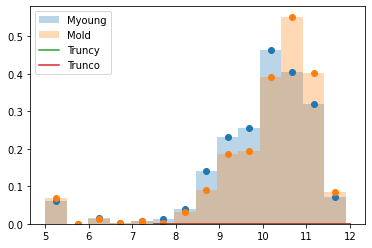

In [171]:
df_snf = df_nc.loc[df_nc['survey'] == 'SNF']

prop = {'density': True, 'alpha': 0.3, 'bins': 14}

hy, by ,_ = plt.hist(df_nc['hostmass'], weights=df_nc['infor'],
                     **prop, label='Myoung')
ho, bo, _ = plt.hist(df_nc['hostmass'], weights=1-df_nc['infor'],
                     **prop, label='Mold')
cy = (by[:-1] + by[1:])/2
co = (bo[:-1] + bo[1:])/2
plt.scatter(cy, hy)
plt.scatter(co, ho)

truncy = scipy.stats.truncnorm.fit(cy, loc=9.5, scale=0.5)#, loc=9.5, scale=3)
trunco = scipy.stats.truncnorm.fit(co, loc=10.5, scale=0.5)#, loc=10.5, scale=3)

print('Truncnorm fit for y:', truncy)
print('Truncnorm fit for o:', trunco)

Mlin = np.linspace(7.5, 12, 1000)

plt.plot(Mlin, scipy.stats.truncnorm.pdf(Mlin, 7, 11, loc=9.3, scale=0.5),
         label='Truncy')
plt.plot(Mlin, scipy.stats.truncnorm.pdf(Mlin, *trunco),
         label='Trunco')

plt.legend()

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1


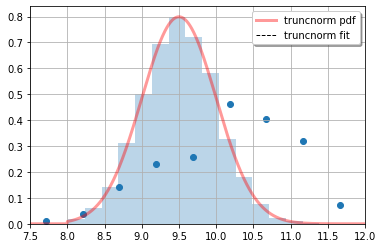

In [176]:
def func(p, r, xa, xb):
    return truncnorm.nnlf(p, r)

def constraint(p, r, xa, xb):
    a, b, loc, scale = p
    return np.array([a*scale + loc - xa, b*scale + loc - xb])

xa, xb = 8, 12 
loc = 9.5
scale = 0.5

a = (xa - loc)/scale
b = (xb - loc)/scale

# Generate some data to work with.
r = truncnorm.rvs(a, b, loc=loc, scale=scale, size=10000)

loc_guess = 9.5
scale_guess = 0.5
a_guess = (xa - loc_guess)/scale_guess
b_guess = (xb - loc_guess)/scale_guess
p0 = [a_guess, b_guess, loc_guess, scale_guess]

par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(cy, xa, xb),
                 iprint=False, iter=1000)
xmin = 7.5
xmax = 12
x = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots(1, 1)
ax.plot(x, truncnorm.pdf(x, a, b, loc=loc, scale=scale),
        'r-', lw=3, alpha=0.4, label='truncnorm pdf')
ax.plot(x, truncnorm.pdf(x, *par),
        'k--', lw=1, alpha=1.0, label='truncnorm fit')
plt.scatter(cy, hy)
ax.hist(r, bins=15, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.xlim(xmin, xmax)
plt.grid(True)

plt.show()

Beta fit for y: (0.9716988759296754, 1.0062242569006916, 8.115233365603906, 3.412806914797262)
Beta fit for o: (0.9716988759296754, 1.0062242569006916, 8.115233365603906, 3.412806914797262)


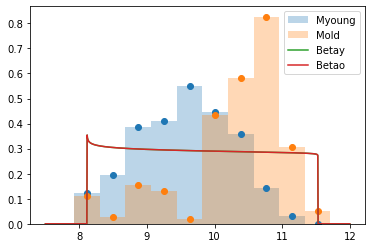

In [159]:
df_snf = df_nc.loc[df_nc['survey'] == 'SNF']

prop = {'density': True, 'alpha': 0.3, 'bins': 10}

hy, by ,_ = plt.hist(df_snf['hostmass'], weights=df_snf['py'],
                     **prop, label='Myoung')
ho, bo, _ = plt.hist(df_snf['hostmass'], weights=1-df_snf['py'],
                     **prop, label='Mold')
cy = (by[:-1] + by[1:])/2
co = (bo[:-1] + bo[1:])/2
plt.scatter(cy, hy)
plt.scatter(co, ho)

truncy = scipy.stats.beta.fit(cy)#, loc=9.5, scale=3)
trunco = scipy.stats.beta.fit(co)#, loc=10.5, scale=3)

print('Beta fit for y:', betay)
print('Beta fit for o:', betao)

Mlin = np.linspace(7.5, 12, 1000)

plt.plot(Mlin, scipy.stats.beta.pdf(Mlin, *betay),
         label='Betay')
plt.plot(Mlin, scipy.stats.beta.pdf(Mlin, *betao),
         label='Betao')

plt.legend()

In [143]:
betay

(0.9564527485523912, 0.9652805596667586, 9.630659495679192, 0.5035758558695193)

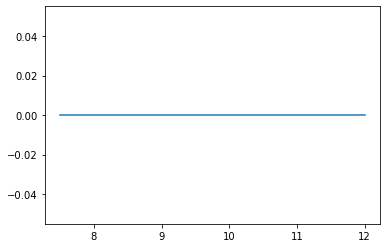

In [142]:
plt.plot(Mlin, scipy.stats.beta.pdf(Mlin, betay[0], betay[1]))


## Plot pretty?

ValueError: weights should have the same shape as x

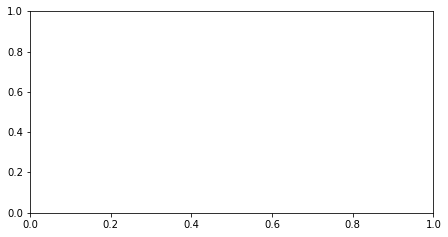

In [10]:
fig = plt.figure(figsize=[7, 3.5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
 
evol3G3M3S.show_hist(ax=ax, bins=15)
evol3G3M3S.show_model(ax=ax,
                 o_factor=-evol3G3M3S.amp*np.sum(1-evol3G3M3S.py),
                 y_factor=evol3G3M3S.amp*np.sum(evol3G3M3S.py),
                 # facealpha=0,
                 # edgealpha=1,
                 lw=1, zorder=8)
 
ax.axvline(0, color='k', lw=1, zorder=10)

#ax.set_xticks([])
ax.set_xlim(-10, 12)
 
ax.set_xlabel(r'$\mathrm{log(LsSFR)}$', fontsize='x-large')
ax.set_ylabel(r'$\mathrm{M}_\mathrm{host}$', fontsize='x-large')

plt.suptitle(evol3G3M3S.__doc__)
 
fig.savefig('../../../Images/pdf/model_mass_' + evol3G3M3S.__doc__ + '_histonly_SED-nonan_all.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/model_mass_' + evol3G3M3S.__doc__ + '_histonly_SED-nonan_all.png',
            bbox_inches='tight', dpi=600)

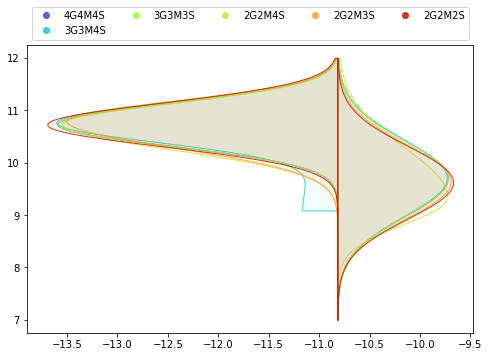

In [15]:
fig = plt.figure(figsize=[10, 5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
#evol4G4M4S.scatter(model=False, ax=ax)
#evol4G4M4S.show_hist(ax, yotext=False, alpha=.1)
evol4G4M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.1, 0.05), eco=plt.cm.turbo(0.1, 0.9),
                      fcy=plt.cm.turbo(0.1, 0.05), ecy=plt.cm.turbo(0.1, 0.9))
                      #o_factor=-evol4G4M4S.amp*np.sum(1-evol4G4M4S.py),
                      #y_factor=evol4G4M4S.amp*np.sum(evol4G4M4S.py))
#evol3G3M4S.show_hist(ax, yotext=False, alpha=0)
evol3G3M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.3, 0.05), eco=plt.cm.turbo(0.3, 0.9),
                      fcy=plt.cm.turbo(0.3, 0.05), ecy=plt.cm.turbo(0.3, 0.9))
                      #o_factor=-evol3G3M4S.amp*np.sum(1-evol3G3M4S.py),
                      #y_factor=evol3G3M4S.amp*np.sum(evol3G3M4S.py))
#evol3G3M3S.show_hist(ax, yotext=False, alpha=0)
evol3G3M3S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.5, 0.05), eco=plt.cm.turbo(0.5, 0.9),
                      fcy=plt.cm.turbo(0.5, 0.05), ecy=plt.cm.turbo(0.5, 0.9))
                      #o_factor=-evol3G3M3S.amp*np.sum(1-evol3G3M3S.py),
                      #y_factor=evol3G3M3S.amp*np.sum(evol3G3M3S.py))
evol2G2M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.6, 0.05), eco=plt.cm.turbo(0.6, 0.9),
                      fcy=plt.cm.turbo(0.6, 0.05), ecy=plt.cm.turbo(0.6, 0.9))
#evol2G2M3S.show_hist(ax, yotext=False, alpha=0)
evol2G2M3S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.7, 0.05), eco=plt.cm.turbo(0.7, 0.9),
                      fcy=plt.cm.turbo(0.7, 0.05), ecy=plt.cm.turbo(0.7, 0.9))
                      #o_factor=-evol2G2M3S.amp*np.sum(1-evol2G2M3S.py),
                      #y_factor=evol2G2M3S.amp*np.sum(evol2G2M3S.py))
#evol2G2M2S.show_hist(ax, yotext=False, alpha=0)
evol2G2M2S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.9, 0.05), eco=plt.cm.turbo(0.9, 0.9),
                      fcy=plt.cm.turbo(0.9, 0.05), ecy=plt.cm.turbo(0.9, 0.9))
                      #o_factor=-evol2G2M2S.amp*np.sum(1-evol2G2M2S.py),
                      #y_factor=evol2G2M2S.amp*np.sum(evol2G2M2S.py))

from matplotlib.lines import Line2D

evol4G4M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.1,0.9), linewidth=0)
evol3G3M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.3,0.9), linewidth=0)
evol3G3M3Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.5,0.9), linewidth=0)
evol2G2M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.6,0.9), linewidth=0)
evol2G2M3Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.7,0.9), linewidth=0)
evol2G2M2Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.9,0.9), linewidth=0)
handles = [evol4G4M4Sleg, evol3G3M4Sleg, evol3G3M3Sleg,
           evol2G2M4Sleg, evol2G2M3Sleg, evol2G2M2Sleg]
labels = ['4G4M4S', '3G3M4S', '3G3M3S', '2G2M4S', '2G2M3S', '2G2M2S']

ax.legend(handles, labels,
          loc='upper center', fontsize='medium', ncol=5,
          bbox_to_anchor=(0.5, 1.0, 0.0, 0.15))

fig.savefig('../../../Images/pdf/models_mass_hist_SED-nonan_all.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/models_mass_hist_SED-nonan_all.png',
            bbox_inches='tight', dpi=600)

### Weird masses to Mat

In [9]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
#sed[(sed['mass'] > 8.2) &
#    (sed['mass'] < 9.)].to_csv('../../../Data/mass/weird_sedsnf.csv', sep=' ')

### Lowz masses to Mat

In [10]:
d = pd.read_csv('../../../Data/sne/data_cheat.csv', sep=' ', index_col='CID')
lowz_df = d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])]
#lowz_df.to_csv('../../../Data/sne/lowz.csv', sep=' ')